In this notebook, we will try to train a Decision-Tree model using permissions from 4287 benign and 3876 malicious android applications.

<h1>Loading Data</h1>

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split



In [13]:
permissions_df = pd.read_csv('../catch-o-extractor/extracted_permissions.csv')
labeled_data_df = pd.read_csv('../catch-o-labeler/labeled_data.csv')

permissions_df = permissions_df.drop(permissions_df.columns[1], axis=1)
permissions_df = permissions_df.rename(columns={permissions_df.columns[0]: 'name'})

In [14]:
df = permissions_df.merge(labeled_data_df, left_on='name', right_on='hash', how='left')

df['detection'] = df['detection'].fillna('benign')

df = df.drop(columns=['hash'])


In [15]:
# Remove rows where detection is 'ransomware'
df = df[df['detection'] != 'ransomware']
df = df[df['detection'] != 'other']
# RF does not combine well with 3 samples from a class
df['detection'].value_counts()

detection
benign      4298
trojan      3179
adware       325
spyware       66
exploit       32
rootkit       11
hacktool       8
Name: count, dtype: int64

In [16]:
# Separate features and labels
X = df.iloc[:, 1:-1]
y = df.iloc[:, -1]

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


<h1>Training the Decision Tree Classifier</h1>

In [18]:
from sklearn.tree import DecisionTreeClassifier

# Initialize the classifier
clf = DecisionTreeClassifier()

clf.fit(X_train, y_train)

DecisionTreeClassifier()

<h1>Evaluate the Model</h1>

In [19]:
y_pred = clf.predict(X_test)

In [20]:
from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')

# Detailed classification report
print(classification_report(y_test, y_pred))


Accuracy: 0.9059343434343434
              precision    recall  f1-score   support

      adware       0.42      0.38      0.40        71
      benign       0.97      0.97      0.97       861
     exploit       0.14      0.11      0.12         9
    hacktool       0.00      0.00      0.00         2
     rootkit       0.00      0.00      0.00         3
     spyware       0.47      0.50      0.49        18
      trojan       0.90      0.91      0.91       620

    accuracy                           0.91      1584
   macro avg       0.41      0.41      0.41      1584
weighted avg       0.90      0.91      0.90      1584



In [21]:
unique_classes = ['adware', 'benign', 'exploit', 'hacktool', 'rootkit', 'spyware', 'trojan']

print(unique_classes)

['adware', 'benign', 'exploit', 'hacktool', 'rootkit', 'spyware', 'trojan']


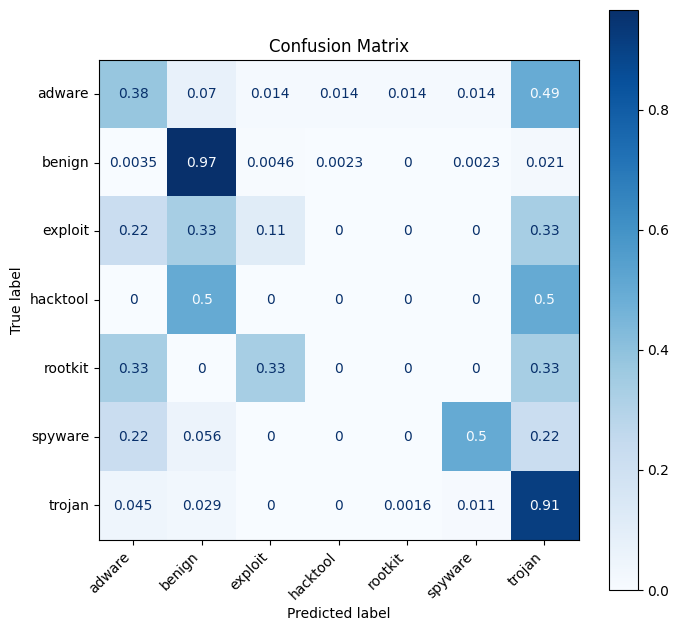

In [22]:
# Create confusion matrix display
fig, ax = plt.subplots(figsize=(10, 10))  # Adjust the figure size
disp = ConfusionMatrixDisplay.from_estimator(clf, X_test, y_test, display_labels=unique_classes, cmap=plt.cm.Blues, normalize='true', ax=ax)

# Adjust label positions
plt.xticks(rotation=45, ha='right')
plt.yticks(va='center')

# Add some padding between the plot and the labels
plt.subplots_adjust(bottom=0.3, left=0.3)

plt.title("Confusion Matrix")
plt.show()

<h1>Hyper-Parameter Tuning</h1>

In [22]:
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.tree import DecisionTreeClassifier

# Define the parameter grid
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Initialize the Decision Tree Classifier
clf = DecisionTreeClassifier()

# Use StratifiedKFold to ensure each fold has a proportional representation of each class
stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Initialize GridSearchCV with StratifiedKFold
grid_search = GridSearchCV(estimator=clf, param_grid=param_grid, cv=stratified_kfold, n_jobs=-1, verbose=2)

# Fit to the training data
grid_search.fit(X_train, y_train)

# Get the best parameters
print(f'Best Parameters: {grid_search.best_params_}')


Fitting 5 folds for each of 72 candidates, totalling 360 fits
[CV] END criterion=gini, max_depth=None, min_samples_leaf=1, min_samples_split=2; total time=  13.9s
[CV] END criterion=gini, max_depth=None, min_samples_leaf=2, min_samples_split=2; total time=  14.0s
[CV] END criterion=gini, max_depth=None, min_samples_leaf=1, min_samples_split=10; total time=  14.1s
[CV] END criterion=gini, max_depth=None, min_samples_leaf=1, min_samples_split=2; total time=  14.1s
[CV] END criterion=gini, max_depth=None, min_samples_leaf=1, min_samples_split=10; total time=  14.1s
[CV] END criterion=gini, max_depth=None, min_samples_leaf=1, min_samples_split=2; total time=  14.1s
[CV] END criterion=gini, max_depth=None, min_samples_leaf=1, min_samples_split=5; total time=  14.2s
[CV] END criterion=gini, max_depth=None, min_samples_leaf=1, min_samples_split=10; total time=  14.1s
[CV] END criterion=gini, max_depth=None, min_samples_leaf=1, min_samples_split=5; total time=  14.2s
[CV] END criterion=gini, m

KeyboardInterrupt: 

Accuracy of the optimal decision tree model: 0.9039

Classification Report:
              precision    recall  f1-score   support

      adware       0.53      0.28      0.36        65
      benign       0.96      0.98      0.97       848
     exploit       0.00      0.00      0.00         7
    hacktool       0.00      0.00      0.00         0
       other       0.57      0.08      0.14        51
     rootkit       0.00      0.00      0.00         2
     spyware       0.40      0.18      0.25        11
      trojan       0.86      0.96      0.91       649

    accuracy                           0.90      1633
   macro avg       0.42      0.31      0.33      1633
weighted avg       0.88      0.90      0.88      1633



/home/kreunt/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/kreunt/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/kreunt/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/kreunt/.local/lib/python

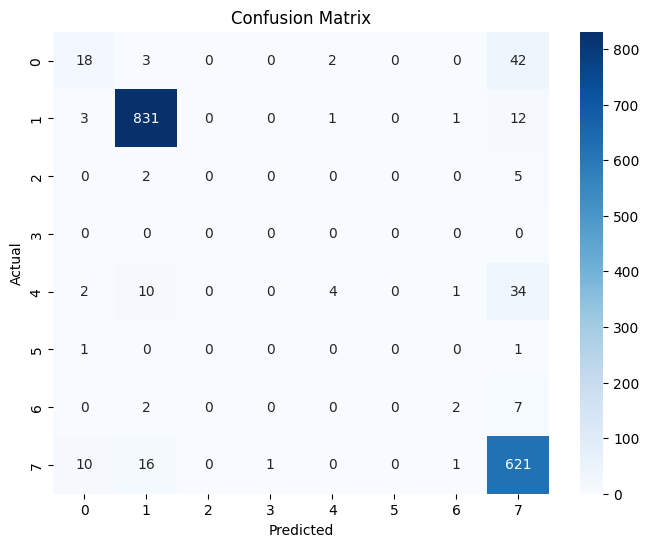

In [ ]:
from matplotlib import pyplot as plt
import seaborn as sns


best_params= grid_search.best_params_
# Fit the decision tree model with optimal parameters
dt_optimal = DecisionTreeClassifier(
    max_depth=best_params['max_depth'],
    min_samples_split=best_params['min_samples_split'],
    min_samples_leaf=best_params['min_samples_leaf'],
    random_state=42
)
dt_optimal.fit(X_train, y_train)

# Make predictions on the test set
y_pred = dt_optimal.predict(X_test)

# Calculate accuracy score
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy of the optimal decision tree model: {accuracy:.4f}")

# Generate classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


<h1>Tree Visualization</h1>

In [ ]:
from sklearn.tree import export_graphviz
import graphviz

# Export the decision tree to a dot file
dot_data = export_graphviz(clf, out_file=None, 
                           feature_names=X.columns,  
                           class_names=clf.classes_.astype(str),
                           filled=True, rounded=True,  
                           special_characters=True)  

# Use graphviz to render the dot file
graph = graphviz.Source(dot_data)  
graph.render("decision_tree")  # Saves the visualization to a file

# To visualize it directly in Jupyter Notebook (if using)
graph.view()


AttributeError: 'DecisionTreeClassifier' object has no attribute 'classes_'